In [2]:
import os
import json

In [87]:
data_root = '/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 3. Multi Label Classification _ 두 개 이상의 선택지에서 여러 객체를 분류하는 분류 방법/실습 파일/Datasets/part1_chapter03_01'
annotation_filename = 'annotations.json'

with open(os.path.join(data_root, annotation_filename), 'r') as json_f:
    annotations = json.load(json_f)

annotations[:3]

[{'filepath': 'green_shirt/915c509883a9b65d343fb7411c973f11d953bd04.jpg',
  'filename': '915c509883a9b65d343fb7411c973f11d953bd04.jpg',
  'classes': ['green', 'shirt']},
 {'filepath': 'green_shirt/d383c34ce5e29eaf0bdac25da27611f5980447ce.jpg',
  'filename': 'd383c34ce5e29eaf0bdac25da27611f5980447ce.jpg',
  'classes': ['green', 'shirt']},
 {'filepath': 'green_shirt/5a1247b420f67634602f86d586c6ec7c4fa47da5.jpg',
  'filename': '5a1247b420f67634602f86d586c6ec7c4fa47da5.jpg',
  'classes': ['green', 'shirt']}]

### Defalut dict 활용해서 클래서 맵 생성

In [88]:
from collections import defaultdict
 
def get_class_map():
    cls_map = defaultdict(int)
    for annot in annotations:
        for cls in annot['classes']:
            cls_map[cls] += 1
    return cls_map

cls_map = get_class_map()
cls_map

defaultdict(int,
            {'green': 1047,
             'shirt': 1686,
             'black': 3130,
             'shoes': 3418,
             'red': 1718,
             'dress': 2570,
             'white': 1812,
             'shorts': 922,
             'pants': 2789,
             'blue': 2863,
             'brown': 815})

In [89]:
print(f'데이터 개수: {len(annotations)}')
print(f'클래스 개수: {len(cls_map)}')
print(f'클래스 이름: {list(cls_map.keys())}')

데이터 개수: 11385
클래스 개수: 11
클래스 이름: ['green', 'shirt', 'black', 'shoes', 'red', 'dress', 'white', 'shorts', 'pants', 'blue', 'brown']


### 3000개 데이터 랜덤추출

In [90]:
import random

random.shuffle(annotations)
annotations = annotations[:10000]

In [91]:
import matplotlib.pyplot as plt

def draw_images(images, classes):
    fig, axs = plt.subplots(2, 4)
    
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i]) 
        ax.set_title(classes[i]) 

    plt.tight_layout()
    plt.show()

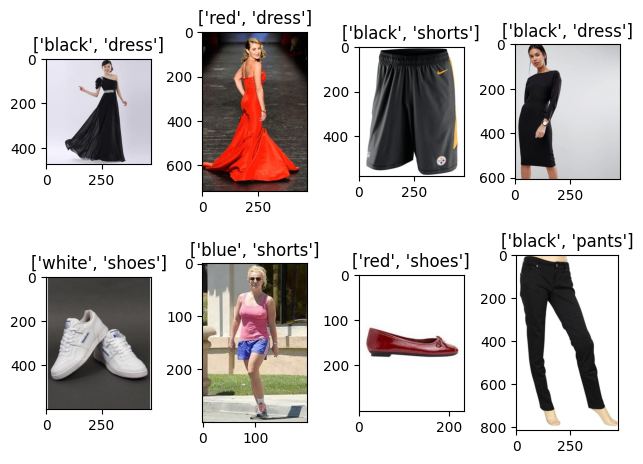

In [92]:
from PIL import Image
import numpy as np
import random

random.shuffle(annotations)

sample_images = [] 
sample_classes = [] 
sample_cnt = 0 
max_cnt = 8

for annot in annotations:
    sample_classes.append(annot['classes'])
    image_path = os.path.join(data_root, annot['filepath'])
    image = Image.open(image_path).convert('RGB')
    sample_images.append(np.array(image))
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

draw_images(sample_images, sample_classes)

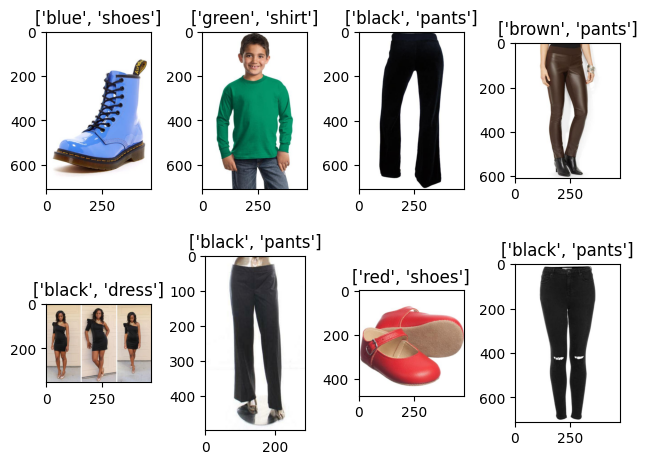

In [93]:
from PIL import Image
import numpy as np
import random

random.shuffle(annotations)

sample_images = [] 
sample_classes = [] 
sample_cnt = 0 
max_cnt = 8

for annot in annotations:
    sample_classes.append(annot['classes'])
    image_path = os.path.join(data_root, annot['filepath'])
    image = Image.open(image_path).convert('RGB')
    sample_images.append(image)
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

draw_images(sample_images, sample_classes)

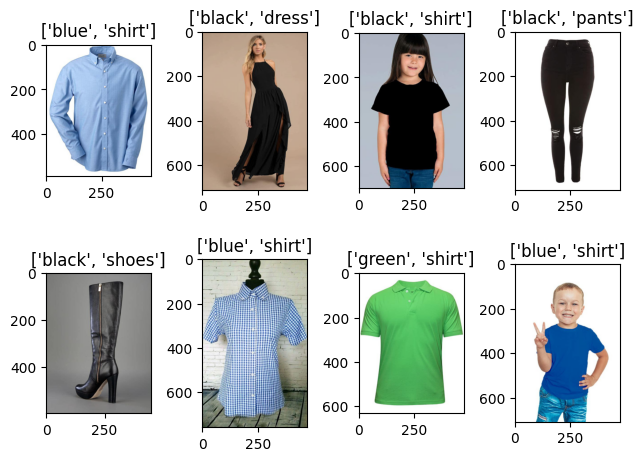

In [94]:
from PIL import Image
import numpy as np
import random

random.shuffle(annotations)
find_cls = ['black', 'shirt'] 
sample_images = []
sample_classes = []
sample_cnt = 0
max_cnt = 8
for annot in annotations:
    cls1, cls2 = annot['classes']
    if (cls1 in find_cls) or (cls2 in find_cls):
        sample_classes.append(annot['classes'])
        image_path = os.path.join(data_root, annot['filepath'])
        image = Image.open(image_path).convert('RGB')
        sample_images.append(np.array(image))
        sample_cnt += 1
        if sample_cnt == max_cnt:
            break
    else:
        continue

draw_images(sample_images, sample_classes)

In [135]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class JsonDataset(Dataset):
    def __init__(self, 
                 data_root,
                 annotations, 
                 transform=None):
        
        self.data_root = data_root
        self.annotations = annotations
        self.transform = transform
        self.class_list = self._get_classes() 
        self.num_classes = len(self.class_list)
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annot = self.annotations[idx]
        image_path = os.path.join(self.data_root, annot['filepath'])
        image = Image.open(image_path).convert("RGB")
        classes = annot['classes']
        
        target = []
        for cls in classes:
            target.append(self.class_list.index(cls))
        target = F.one_hot(torch.tensor(target), self.num_classes).sum(dim=0).to(torch.float)
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, target
    
    def _get_classes(self):
        
        class_set = set()
        for annot in self.annotations:
            for cls in annot['classes']:
                class_set.add(cls)
        class_list = list(class_set)
        class_list.sort()
        return class_list

In [136]:
dataset = JsonDataset(data_root, annotations)

In [137]:
print(dataset[1][1])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])


In [138]:
dataset.class_list

['black',
 'blue',
 'brown',
 'dress',
 'green',
 'pants',
 'red',
 'shirt',
 'shoes',
 'shorts',
 'white']

### 데이터셋 분할

In [155]:
random.shuffle(annotations)
len_annot = len(annotations)
train_annot = annotations[ : int(len_annot * 0.9)]
val_annot = annotations[int(len_annot * 0.9) : ]

print(f'학습 데이터 개수 : {len(train_annot)}')
print(f'검증 데이터 개수 : {len(val_annot)}')

학습 데이터 개수 : 9000
검증 데이터 개수 : 1000


In [156]:
print(f'train 데이터 개수: {len(train_annot)}')
print(f'val 데이터 개수: {len(val_annot)}')

train 데이터 개수: 9000
val 데이터 개수: 1000


In [182]:
hyper_params = {
    'num_epochs': 5,
    'learning_rate': 0.0001,
    'score_threshold': 0.5,
    'image_size': 224,
    'batch_size': 32,
    'num_workers': 4,
    'print_freq': 0.1
}

### Albumentations 이미지 변환 활용

In [158]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

sample_transform = A.Compose([
    A.Resize(height=hyper_params['image_size'], width=hyper_params['image_size']), 
    A.HorizontalFlip(p=0.5),  
    A.Rotate(limit=15, p=0.3),  
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),  
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),  # 채도 조정
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),  
    A.CLAHE(clip_limit=2.0, p=0.1),  
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # ToTensorV2()
])

In [159]:
sample_dataset = JsonDataset(data_root, annotations, sample_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656861..2.5877123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637811..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431371..2.5877123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793

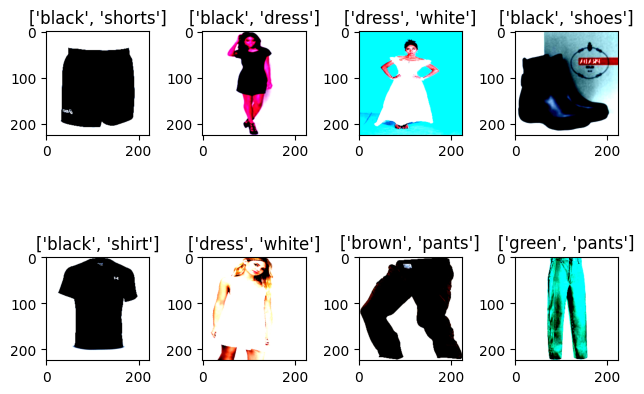

In [160]:
transformed_images = []
targets = []

max_cnt = 8
for idx, (image, target) in enumerate(sample_dataset):
    if idx == max_cnt:
        break
    transformed_images.append(image)
    targets.append(target.tolist())

## 타켓 벡터를 클래스로 변환한다.
target_classes = []
class_list = sample_dataset.class_list
for target in targets:
    classes = []
    for cls, val in enumerate(target):
        if int(val) == 1:
            classes.append(class_list[cls])
    target_classes.append(classes)

draw_images(transformed_images, target_classes)

In [161]:
transform = A.Compose([
    A.Resize(height=hyper_params['image_size'], width=hyper_params['image_size']), 
    A.HorizontalFlip(p=0.5),  
    A.Rotate(limit=15, p=0.3),  
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),  
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),  # 채도 조정
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),  
    A.CLAHE(clip_limit=2.0, p=0.1),  
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [164]:

train_dataset = JsonDataset(data_root, train_annot, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['batch_size'], shuffle=True)

val_dataset = JsonDataset(data_root, val_annot, transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hyper_params['batch_size'], shuffle=False)

### 모델 생성

In [166]:
import torch
import torch.nn as nn
import timm 

model = timm.create_model('vit_base_patch16_224.augreg2_in21k_ft_in1k', pretrained=True, num_classes=len(cls_map))


/opt/anaconda3/envs/multilabel1204/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [167]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

ViT 튜닝

In [174]:
model.head = nn.Linear(model.head.in_features, len(cls_map), bias=True)
model.head_drop = nn.Dropout(p=0.1)

In [175]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### 모델 학습 및 검증

In [178]:
import wandb
import random
import math
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: datafullstack0514 (datafullstack0514-person). Use `wandb login --relogin` to force relogin


True

In [180]:
wandb.init(
    project="cloth_class")

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from lion_pytorch import Lion


criterion = nn.BCEWithLogitsLoss()
optimizer = Lion(model.parameters(), lr=hyper_params['learning_rate'], weight_decay=1e-2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = hyper_params['num_epochs']

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * hyper_params['print_freq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, targets)

        # backward & update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        wandb.log({"loss": loss})

        if idx % print_cnt == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {running_loss/print_cnt:.4f}")
            running_loss = 0.0
        
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")
    wandb.log({"loss": epoch_loss/len(train_dataloader)})

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images)) 
            preds = (outputs > hyper_params['score_threshold']).float() 
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='micro')  
    print(f"F1-score: {f1:.4f}")

Epoch [1/5], Iter [0/282] Loss: 0.0078


KeyboardInterrupt: 